# Adult EO Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
from voting_classifier import VotingClassifier

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def evaluate_fairness(y_true, y_pred, sensitive_features):
    """
    Evaluates fairness of the final majority vote classifier over T_inner hypotheses
    on the test set.
    #NOTE: defined in the meta_algo file, but we chose:
    a0 := African-American (COMPAS), Female (Adult)
    a1 := Caucasian (COMPAS), Male (Adult)

    :return: list. subgroups in sensitive_features.
    :return: list, dict, dict. groups is a list of the sensitive features in the dataset. 
    group_metrics is a dictionary containing dictionaries that have Delta_dp, Delta_eoy0, 
    and Delta_eoy1 for each group. gaps is a dictionary that contains the fairness gap
    for dp, eo_y0 and eo_y1.
    """
    groups = np.unique(sensitive_features.values)
    pos_count = {}
    dp_pct = {}
    eo_y0_pct = {}
    eo_y1_pct = {}

    for index, group in enumerate(groups):
        # Demographic Parity
        indices = {}
        indices[group] = sensitive_features.index[sensitive_features == group]
        dp_pct[group] = sum(y_pred[indices[group]])/len(indices[group])

        # Equalized Odds
        y1_indices = {}
        y0_indices = {}
        y1_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 1)]
        y0_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 0)]
        eo_y0_pct[group] = sum(y_pred[y0_indices[group]])/len(y0_indices[group])   
        eo_y1_pct[group] = sum(y_pred[y1_indices[group]])/len(y1_indices[group])

    gaps = {}
    group_metrics = {} # a dictionary of dictionaries

    gaps['dp'] = abs(dp_pct[groups[0]] - dp_pct[groups[1]])
    gaps['eo_y0'] = abs(eo_y0_pct[groups[0]] - eo_y0_pct[groups[1]])
    gaps['eo_y1'] = abs(eo_y1_pct[groups[0]] - eo_y1_pct[groups[1]])
    group_metrics['dp'] = dp_pct
    group_metrics['eo_y0'] = eo_y0_pct
    group_metrics['eo_y1'] = eo_y1_pct

    return groups, group_metrics, gaps

In [3]:
def set_a_indices(sensitive_features, y):
    """
    Creates a dictionary a_indices that contains the necessary information for which indices
    contain the sensitive/protected attributes.

    :return: dict 'a_indices' which contains a list of the a_0 indices, list of a_1 indices,
    list of a_0 indices where y = 0, list of a_0 indices where y = 1, list of a_1 indices
    where y = 0, list of a_1 indices where y = 1, and a list containing the a value of each sample.
    """
    a_indices = dict()
    a_indices['a0'] = sensitive_features.index[sensitive_features.eq(0)].tolist()
    a_indices['a1'] = sensitive_features.index[sensitive_features.eq(1)].tolist()
    a_indices['all'] = sensitive_features.tolist()

    y0 = set(np.where(y == 0)[0])
    y1 = set(np.where(y == 1)[0])
    a_indices['a0_y0'] = list(y0.intersection(set(a_indices['a0'])))
    a_indices['a0_y1'] = list(y1.intersection(set(a_indices['a0'])))
    a_indices['a1_y0'] = list(y0.intersection(set(a_indices['a1'])))
    a_indices['a1_y1'] = list(y1.intersection(set(a_indices['a1'])))

    assert(len(a_indices['a0']) + len(a_indices['a1']) == len(y))
    assert(len(a_indices['a0_y0']) + len(a_indices['a0_y1']) + len(a_indices['a1_y0']) + len(a_indices['a1_y1']) == len(y))
    return a_indices

def set_proportions(a_indices, y, fair_constraint):
    proportions = {}
    proportions['a0'] = len(a_indices['a0'])/float(len(y))
    proportions['a1'] = len(a_indices['a1'])/float(len(y))
    proportions['a0_y0'] = len(a_indices['a0_y0'])/float(len(y))
    proportions['a0_y1'] = len(a_indices['a0_y1'])/float(len(y))
    proportions['a1_y0'] = len(a_indices['a1_y0'])/float(len(y))
    proportions['a1_y1'] = len(a_indices['a1_y1'])/float(len(y))
    proportions['y0'] = (len(np.where(y == 0)[0]))/float(len(y))
    proportions['y1'] = (len(np.where(y == 1)[0]))/float(len(y))

    print('y0 proportion = {}'.format(proportions['y0']))
    print('y1 proportion = {}'.format(proportions['y1']))
    print('a0 proportion = {}'.format(proportions['a0']))
    print('a1 proportion = {}'.format(proportions['a1']))
    print('a0 y0 proportion = {}'.format(proportions['a0_y0']))
    print('a1 y0 proportion = {}'.format(proportions['a1_y0']))
    print('a0 y1 proportion = {}'.format(proportions['a0_y1']))
    print('a1 y1 proportion = {}'.format(proportions['a1_y1']))

    assert(proportions['y0'] + proportions['y1'] == 1)
    assert(proportions['a0'] + proportions['a1'] == 1)
    #assert(proportions['a0_y0'] + proportions['a0_y1'] + proportions['a1_y0'] + proportions['a1_y1'] == 1)

    return proportions

In [4]:
def std_error(arr):
    std = np.std(arr)
    return std/np.sqrt(len(arr))

## Import Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. 

In [5]:
X_train_arr = []
X_test_arr = []
y_train_arr = []
y_test_arr = []
sensitive_features_train_arr = []
sensitive_features_test_arr = []

for i in range(5):
    X_train = pd.read_csv('./../../data/processed/adult/adult_train{}_X.csv'.format(i + 1))
    X_test = pd.read_csv('./../../data/processed/adult/adult_test{}_X.csv'.format(i + 1))
    y_train = pd.read_csv('./../../data/processed/adult/adult_train{}_y.csv'.format(i + 1))
    y_test = pd.read_csv('./../../data/processed/adult/adult_test{}_y.csv'.format(i + 1))

    y_train = y_train['income']
    y_test = y_test['income']
    
    sensitive_features_train = X_train['sex']
    sensitive_features_test = X_test['sex']

    sensitive_features_train[sensitive_features_train <= 0] = 0
    sensitive_features_train[sensitive_features_train > 0] = 1
    sensitive_features_train = sensitive_features_train.reset_index(drop=True)
    
    sensitive_features_test[sensitive_features_test <= 0] = 0
    sensitive_features_test[sensitive_features_test > 0] = 1
    sensitive_features_test = sensitive_features_test.reset_index(drop=True)
    
    X_train_arr.append(X_train)
    X_test_arr.append(X_test)
    y_train_arr.append(y_train)
    y_test_arr.append(y_test)
    sensitive_features_train_arr.append(sensitive_features_train)
    sensitive_features_test_arr.append(sensitive_features_test)

In [6]:
print(X_train_arr[0].shape)
print(X_test_arr[0].shape)
print(y_train_arr[0].shape)
print(y_test_arr[0].shape)
print(len(X_train_arr))

(1616, 98)
(404, 98)
(1616,)
(404,)
5


In [7]:
a_indices_train_arr = []
a_indices_test_arr = []

for i in range(5):
    a_indices_train_arr.append(set_a_indices(sensitive_features_train_arr[i], y_train_arr[i]))
    a_indices_test_arr.append(set_a_indices(sensitive_features_test_arr[i], y_test_arr[i]))

In [8]:
proportions_train_arr = []
proportions_test_arr = []

for i in range(5):
    proportions_train_arr.append(set_proportions(a_indices_train_arr[i], y_train_arr[i], 'eo'))
    proportions_test_arr.append(set_proportions(a_indices_test_arr[i], y_test_arr[i], 'eo'))

y0 proportion = 0.49504950495049505
y1 proportion = 0.504950495049505
a0 proportion = 0.7425742574257426
a1 proportion = 0.25742574257425743
a0 y0 proportion = 0.30383663366336633
a1 y0 proportion = 0.19121287128712872
a0 y1 proportion = 0.43873762376237624
a1 y1 proportion = 0.06621287128712872
y0 proportion = 0.5173267326732673
y1 proportion = 0.48267326732673266
a0 proportion = 0.7376237623762376
a1 proportion = 0.2623762376237624
a0 y0 proportion = 0.3193069306930693
a1 y0 proportion = 0.19801980198019803
a0 y1 proportion = 0.4183168316831683
a1 y1 proportion = 0.06435643564356436
y0 proportion = 0.5030940594059405
y1 proportion = 0.4969059405940594
a0 proportion = 0.7419554455445545
a1 proportion = 0.25804455445544555
a0 y0 proportion = 0.31064356435643564
a1 y0 proportion = 0.19245049504950495
a0 y1 proportion = 0.4313118811881188
a1 y1 proportion = 0.0655940594059406
y0 proportion = 0.48514851485148514
y1 proportion = 0.5148514851485149
a0 proportion = 0.7400990099009901
a1 prop

## Train and Predict (Preprocessing)

## Train and Predict (Inprocessing)

In [9]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds

inprocessing_clfrs = []
inprocessing_test_accs = []
inprocessing_dps = []
inprocessing_preds = []

In [10]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    inprocessing_dp = ExponentiatedGradient(
        LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'),
        constraints=EqualizedOdds(),
        eps=0.05,
        nu=1e-6)

    inprocessing_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    inprocessing_y_pred = inprocessing_dp.predict(X_test)

    print("Adult Test Accuracy (Inprocessing, EO): {}".format(accuracy_score(inprocessing_y_pred, y_test)))
    groups, group_metrics_eo, gaps_eo = evaluate_fairness(y_test, inprocessing_y_pred, sensitive_features_test)

    for group in groups:
        print("P[h(X) = 1 | A = {}, Y = 1] = {}".format(group, group_metrics_eo['eo_y1'][group]))
        print("P[h(X) = 1 | A = {}, Y = 0] = {}".format(group, group_metrics_eo['eo_y0'][group]))
    print("Delta_eo1 = {}".format(gaps_eo['eo_y1']))
    print("Delta_eo0 = {}".format(gaps_eo['eo_y0']))
    
    inprocessing_clfrs.append(inprocessing_dp)
    inprocessing_test_accs.append(accuracy_score(inprocessing_y_pred, y_test))
    inprocessing_preds.append(inprocessing_y_pred)

Adult Test Accuracy (Inprocessing, EO): 0.8193069306930693
P[h(X) = 1 | A = 0.0, Y = 1] = 0.8106508875739645
P[h(X) = 1 | A = 0.0, Y = 0] = 0.1937984496124031
P[h(X) = 1 | A = 1.0, Y = 1] = 0.8846153846153846
P[h(X) = 1 | A = 1.0, Y = 0] = 0.1625
Delta_eo1 = 0.07396449704142005
Delta_eo0 = 0.031298449612403106
Adult Test Accuracy (Inprocessing, EO): 0.7945544554455446
P[h(X) = 1 | A = 0.0, Y = 1] = 0.7790055248618785
P[h(X) = 1 | A = 0.0, Y = 0] = 0.2033898305084746
P[h(X) = 1 | A = 1.0, Y = 1] = 0.7777777777777778
P[h(X) = 1 | A = 1.0, Y = 0] = 0.16666666666666666
Delta_eo1 = 0.0012277470841006721
Delta_eo0 = 0.03672316384180793
Adult Test Accuracy (Inprocessing, EO): 0.7599009900990099
P[h(X) = 1 | A = 0.0, Y = 1] = 0.7486033519553073
P[h(X) = 1 | A = 0.0, Y = 0] = 0.2636363636363636
P[h(X) = 1 | A = 1.0, Y = 1] = 0.6666666666666666
P[h(X) = 1 | A = 1.0, Y = 0] = 0.15294117647058825
Delta_eo1 = 0.08193668528864062
Delta_eo0 = 0.11069518716577537
Adult Test Accuracy (Inprocessing, EO)

## Train and Predict (Postprocessing)

In [11]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

postprocessing_clfrs = []
postprocessing_test_accs = []
postprocessing_dps = []
postprocessing_preds = []

In [12]:
class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores

In [13]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    estimator_wrapper = LogisticRegressionAsRegression(logreg).fit(X_train, y_train)
    postprocessed_predictor_dp = ThresholdOptimizer(estimator=estimator_wrapper, constraints="equalized_odds", prefit=True)

    postprocessed_predictor_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    postprocessing_y_pred = postprocessed_predictor_dp.predict(X_test, sensitive_features=sensitive_features_test)

    print("Adult Test Accuracy (Postprocessing, EO): {}".format(accuracy_score(postprocessing_y_pred, y_test)))
    groups, group_metrics_eo, gaps_eo = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)

    for group in groups:
        print("P[h(X) = 1 | A = {}, Y = 1] = {}".format(group, group_metrics_eo['eo_y1'][group]))
        print("P[h(X) = 1 | A = {}, Y = 0] = {}".format(group, group_metrics_eo['eo_y0'][group]))
    print("Delta_eo1 = {}".format(gaps_eo['eo_y1']))
    print("Delta_eo0 = {}".format(gaps_eo['eo_y0']))

    postprocessing_clfrs.append(postprocessed_predictor_dp)
    postprocessing_test_accs.append(accuracy_score(postprocessing_y_pred, y_test))
    postprocessing_preds.append(postprocessing_y_pred)

Adult Test Accuracy (Postprocessing, EO): 0.806930693069307
P[h(X) = 1 | A = 0.0, Y = 1] = 0.834319526627219
P[h(X) = 1 | A = 0.0, Y = 0] = 0.20930232558139536
P[h(X) = 1 | A = 1.0, Y = 1] = 0.8461538461538461
P[h(X) = 1 | A = 1.0, Y = 0] = 0.2375
Delta_eo1 = 0.011834319526627168
Delta_eo0 = 0.02819767441860463
Adult Test Accuracy (Postprocessing, EO): 0.7995049504950495
P[h(X) = 1 | A = 0.0, Y = 1] = 0.850828729281768
P[h(X) = 1 | A = 0.0, Y = 0] = 0.2457627118644068
P[h(X) = 1 | A = 1.0, Y = 1] = 0.7777777777777778
P[h(X) = 1 | A = 1.0, Y = 0] = 0.24358974358974358
Delta_eo1 = 0.07305095150399021
Delta_eo0 = 0.002172968274663206
Adult Test Accuracy (Postprocessing, EO): 0.7722772277227723
P[h(X) = 1 | A = 0.0, Y = 1] = 0.7821229050279329
P[h(X) = 1 | A = 0.0, Y = 0] = 0.2545454545454545
P[h(X) = 1 | A = 1.0, Y = 1] = 0.7333333333333333
P[h(X) = 1 | A = 1.0, Y = 0] = 0.2
Delta_eo1 = 0.04878957169459963
Delta_eo0 = 0.05454545454545451
Adult Test Accuracy (Postprocessing, EO): 0.8267326

## Predict (Robust Algorithm h_0, T = 1000)

In [14]:
robust_clfrs = []
robust_test_accs = []
robust_dps = []
robust_preds = []

In [15]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    pickled_file = './robust_classifiers/finalh0eo_adult/h0_finalh0eo_adult1000split{}.pkl'.format(i+1)
    pickled_robust_h = open(pickled_file, "rb")
    robust_h = pickle.load(pickled_robust_h)
    robust_pred = robust_h.predict(X_test)
    print("Adult Test Accuracy (Robust, EO): {}".format(accuracy_score(robust_pred, y_test)))
    groups, group_metrics_eo, gaps_eo = evaluate_fairness(y_test, robust_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | A = {}, Y = 1] = {}".format(group, group_metrics_eo['eo_y1'][group]))
        print("P[h(X) = 1 | A = {}, Y = 0] = {}".format(group, group_metrics_eo['eo_y0'][group]))
    print("Delta_eo1 = {}".format(gaps_eo['eo_y1']))
    print("Delta_eo0 = {}".format(gaps_eo['eo_y0']))
    
    robust_clfrs.append(robust_h)
    robust_test_accs.append(accuracy_score(robust_pred, y_test))
    robust_preds.append(robust_pred)

Adult Test Accuracy (Robust, EO): 0.6881188118811881
P[h(X) = 1 | A = 0.0, Y = 1] = 0.44970414201183434
P[h(X) = 1 | A = 0.0, Y = 0] = 0.05426356589147287
P[h(X) = 1 | A = 1.0, Y = 1] = 0.038461538461538464
P[h(X) = 1 | A = 1.0, Y = 0] = 0.0125
Delta_eo1 = 0.41124260355029585
Delta_eo0 = 0.04176356589147287
Adult Test Accuracy (Robust, EO): 0.6782178217821783
P[h(X) = 1 | A = 0.0, Y = 1] = 0.4143646408839779
P[h(X) = 1 | A = 0.0, Y = 0] = 0.0423728813559322
P[h(X) = 1 | A = 1.0, Y = 1] = 0.37037037037037035
P[h(X) = 1 | A = 1.0, Y = 0] = 0.02564102564102564
Delta_eo1 = 0.04399427051360755
Delta_eo0 = 0.01673185571490656
Adult Test Accuracy (Robust, EO): 0.650990099009901
P[h(X) = 1 | A = 0.0, Y = 1] = 0.39106145251396646
P[h(X) = 1 | A = 0.0, Y = 0] = 0.06363636363636363
P[h(X) = 1 | A = 1.0, Y = 1] = 0.3
P[h(X) = 1 | A = 1.0, Y = 0] = 0.047058823529411764
Delta_eo1 = 0.09106145251396647
Delta_eo0 = 0.016577540106951866
Adult Test Accuracy (Robust, EO): 0.7153465346534653
P[h(X) = 1 | 

## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [16]:
def EO_linear_prog(y_pred, a_indices, proportions, lower_bound, upper_bound, a, a_p, y_value):
    # Make sure constraint is within bounds
    assert(0 < lower_bound < 1)
    assert(0 < upper_bound < 1)
    
    if(y_value != 'y0' and y_value != 'y1'):
        return("Enter y0 or y1 for the second argument (y_value for eo).")
    
    # Setup variables and subgp names
    n = len(y_pred)
    w = cp.Variable(n)
    a_y = a + '_' + y_value
    a_p_y = a_p + '_' + y_value
    excluded_subgroups = list({"a0_y0", "a0_y1", "a1_y0", "a1_y1"}.difference(set([a_y, a_p_y])))
    
    # Setup prediction vector
    h_xi_a = y_pred.copy()
    h_xi_a[a_indices[a_p_y]] = 0
    for gp in excluded_subgroups:
        h_xi_a[a_indices[gp]] = 0
    h_xi_ap = y_pred.copy()
    h_xi_ap[a_indices[a_y]] = 0
    for gp in excluded_subgroups:
        h_xi_ap[a_indices[gp]] = 0
    
    # Setup subgroup proportions
    pi_a = proportions[a_y]
    pi_a_p = proportions[a_p_y]
    
    # Set constraints
    constraints = [
        cp.sum(w[a_indices[a_y]]) == pi_a,
        cp.sum(w[a_indices[a_p_y]]) == pi_a_p,
        cp.sum(w) == 1,
        0 <= w,
        lower_bound <= w,
        w <= upper_bound
    ]
    
    for group in excluded_subgroups:
        constraints.append(w[a_indices[group]] == 1/n)
        
    # Setup objective and problem
    objective = cp.Maximize(((1/pi_a) * (w @ h_xi_a)) - ((1/pi_a_p) * (w @ h_xi_ap)))
    problem = cp.Problem(objective, constraints)
    
    # Solve problem
    problem.solve(solver = 'ECOS')
    return problem.value, w.value

## Experiment with Linear Program (Y = 0)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [17]:
epsilon_granule = 0.01

inprocessing_objective_values_y0 = []
postprocessing_objective_values_y0 = []
robust_objective_values_y0 = []

# Iterate over datasets
for s in range(5):
    inprocessing_y_pred = inprocessing_preds[s]
    postprocessing_y_pred = postprocessing_preds[s]
    robust_pred = robust_preds[s]
    a_indices_test = a_indices_test_arr[s]
    proportions_test = proportions_test_arr[s]
    
    inprocessing_curr = []
    postprocessing_curr = []
    robust_curr = []
    # Iterate over constraints
    for i in range(0, int(1/epsilon_granule)):
        epsilon = epsilon_granule * i
        lower_bound = (1 - epsilon)/(len(X_test))
        upper_bound = (1 + epsilon)/(len(X_test))

        inprocessing_objective_value_a0a1, w = EO_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1', 'y0')
        inprocessing_objective_value_a1a0, w = EO_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0', 'y0')
        inprocessing_objective_value = max(inprocessing_objective_value_a0a1, inprocessing_objective_value_a1a0)
        inprocessing_curr.append(inprocessing_objective_value)

        postprocessing_objective_value_a0a1, w = EO_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1', 'y0')
        postprocessing_objective_value_a1a0, w = EO_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0', 'y0')
        postprocessing_objective_value = max(postprocessing_objective_value_a0a1, postprocessing_objective_value_a1a0)
        postprocessing_curr.append(postprocessing_objective_value)

        robust_objective_value_a0a1, w = EO_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1', 'y0')
        robust_objective_value_a1a0, w = EO_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0', 'y0')
        robust_objective_value = max(robust_objective_value_a0a1, robust_objective_value_a1a0)
        robust_curr.append(robust_objective_value)
    
    inprocessing_objective_values_y0.append(np.asarray(inprocessing_curr))
    postprocessing_objective_values_y0.append(np.asarray(postprocessing_curr))
    robust_objective_values_y0.append(np.asarray(robust_curr))

In [18]:
epsilons = []
for i in range(0, int(1/epsilon_granule)):
    epsilons.append(i * epsilon_granule)

In [19]:
# Average over the results
inprocessing_avg_objective_values_y0 = np.zeros(len(inprocessing_objective_values_y0[0]))
postprocessing_avg_objective_values_y0 = np.zeros(len(postprocessing_objective_values_y0[0]))
robust_avg_objective_values_y0 = np.zeros(len(robust_objective_values_y0[0]))

for i in range(1,5):
    inprocessing_avg_objective_values_y0 += inprocessing_objective_values_y0[i]
    postprocessing_avg_objective_values_y0 += postprocessing_objective_values_y0[i]
    robust_avg_objective_values_y0 += robust_objective_values_y0[i]
    
inprocessing_avg_objective_values_y0 = np.divide(inprocessing_avg_objective_values_y0, 4)
postprocessing_avg_objective_values_y0 = np.divide(postprocessing_avg_objective_values_y0, 4)
robust_avg_objective_values_y0 = np.divide(robust_avg_objective_values_y0, 4)

In [20]:
inprocessing_std_err = []
postprocessing_std_err = []
robust_std_err = []

for i in range(100):
    inprocessing_vals = []
    postprocessing_vals = []
    robust_vals = []
    
    for s in range(1,5):
        inprocessing_vals.append(inprocessing_objective_values_y0[s][i])
        postprocessing_vals.append(postprocessing_objective_values_y0[s][i])
        robust_vals.append(robust_objective_values_y0[s][i])
        
    inprocessing_std_err.append(std_error(inprocessing_vals))
    postprocessing_std_err.append(std_error(postprocessing_vals))
    robust_std_err.append(std_error(robust_vals))

Text(0.5, 1.0, 'Adult Comparison (h0, EOy0, T=1000)')

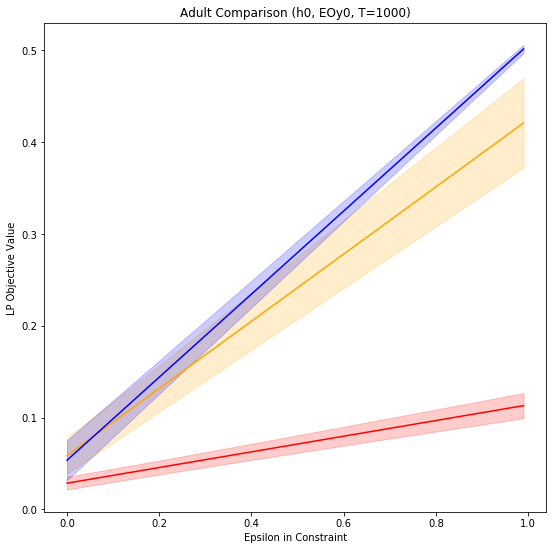

In [21]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, inprocessing_avg_objective_values_y0, 'orange')
plt.plot(epsilons, postprocessing_avg_objective_values_y0, 'blue')
plt.plot(epsilons, robust_avg_objective_values_y0, 'red')
plt.fill_between(epsilons, inprocessing_avg_objective_values_y0 - inprocessing_std_err, inprocessing_avg_objective_values_y0 + inprocessing_std_err, color='orange', alpha=0.2)
plt.fill_between(epsilons, postprocessing_avg_objective_values_y0 - postprocessing_std_err, postprocessing_avg_objective_values_y0 + postprocessing_std_err, color='blue', alpha=0.2)
plt.fill_between(epsilons, robust_avg_objective_values_y0 - robust_std_err, robust_avg_objective_values_y0 + robust_std_err, color='red', alpha=0.2)
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Adult Comparison (h0, EOy0, T=1000)')

## Experiment with Linear Program (Y = 1)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [22]:
epsilon_granule = 0.01

inprocessing_objective_values_y1 = []
postprocessing_objective_values_y1 = []
robust_objective_values_y1 = []

# Iterate over datasets
for s in range(5):
    inprocessing_y_pred = inprocessing_preds[s]
    postprocessing_y_pred = postprocessing_preds[s]
    robust_pred = robust_preds[s]
    a_indices_test = a_indices_test_arr[s]
    proportions_test = proportions_test_arr[s]
    
    inprocessing_curr = []
    postprocessing_curr = []
    robust_curr = []
    # Iterate over constraints
    for i in range(0, int(1/epsilon_granule)):
        epsilon = epsilon_granule * i
        lower_bound = (1 - epsilon)/(len(X_test))
        upper_bound = (1 + epsilon)/(len(X_test))

        inprocessing_objective_value_a0a1, w = EO_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1', 'y1')
        inprocessing_objective_value_a1a0, w = EO_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0', 'y1')
        inprocessing_objective_value = max(inprocessing_objective_value_a0a1, inprocessing_objective_value_a1a0)
        inprocessing_curr.append(inprocessing_objective_value)

        postprocessing_objective_value_a0a1, w = EO_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1', 'y1')
        postprocessing_objective_value_a1a0, w = EO_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0', 'y1')
        postprocessing_objective_value = max(postprocessing_objective_value_a0a1, postprocessing_objective_value_a1a0)
        postprocessing_curr.append(postprocessing_objective_value)

        robust_objective_value_a0a1, w = EO_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1', 'y1')
        robust_objective_value_a1a0, w = EO_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0', 'y1')
        robust_objective_value = max(robust_objective_value_a0a1, robust_objective_value_a1a0)
        robust_curr.append(robust_objective_value)
    
    inprocessing_objective_values_y1.append(np.asarray(inprocessing_curr))
    postprocessing_objective_values_y1.append(np.asarray(postprocessing_curr))
    robust_objective_values_y1.append(np.asarray(robust_curr))

In [23]:
epsilons = []
for i in range(0, int(1/epsilon_granule)):
    epsilons.append(i * epsilon_granule)

In [24]:
# Average over the results
inprocessing_avg_objective_values_y1 = np.zeros(len(inprocessing_objective_values_y1[0]))
postprocessing_avg_objective_values_y1 = np.zeros(len(postprocessing_objective_values_y1[0]))
robust_avg_objective_values_y1 = np.zeros(len(robust_objective_values_y1[0]))

for i in range(1,5):
    inprocessing_avg_objective_values_y1 += inprocessing_objective_values_y1[i]
    postprocessing_avg_objective_values_y1 += postprocessing_objective_values_y1[i]
    robust_avg_objective_values_y1 += robust_objective_values_y1[i]
    
inprocessing_avg_objective_values_y1 = np.divide(inprocessing_avg_objective_values_y1, 4)
postprocessing_avg_objective_values_y1 = np.divide(postprocessing_avg_objective_values_y1, 4)
robust_avg_objective_values_y1 = np.divide(robust_avg_objective_values_y1, 4)

In [25]:
inprocessing_std_err = []
postprocessing_std_err = []
robust_std_err = []

for i in range(100):
    inprocessing_vals = []
    postprocessing_vals = []
    robust_vals = []
    
    for s in range(1,5):
        inprocessing_vals.append(inprocessing_objective_values_y1[s][i])
        postprocessing_vals.append(postprocessing_objective_values_y1[s][i])
        robust_vals.append(robust_objective_values_y1[s][i])
        
    inprocessing_std_err.append(std_error(inprocessing_vals))
    postprocessing_std_err.append(std_error(postprocessing_vals))
    robust_std_err.append(std_error(robust_vals))

Text(0.5, 1.0, 'Adult Comparison (h0, EOy1, T=1000)')

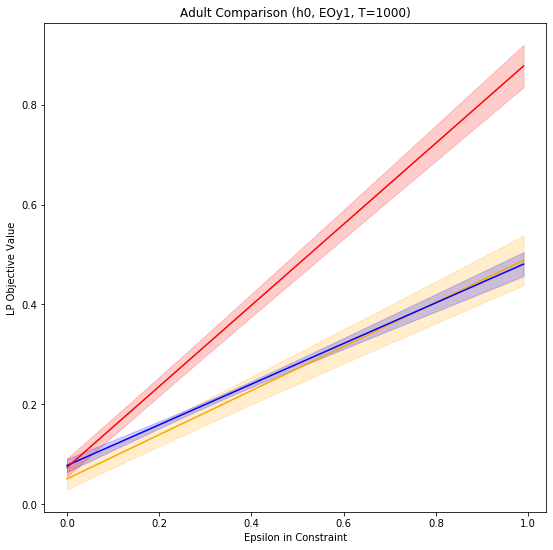

In [26]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, inprocessing_avg_objective_values_y1, 'orange')
plt.plot(epsilons, postprocessing_avg_objective_values_y1, 'blue')
plt.plot(epsilons, robust_avg_objective_values_y1, 'red')
plt.fill_between(epsilons, inprocessing_avg_objective_values_y1 - inprocessing_std_err, inprocessing_avg_objective_values_y1 + inprocessing_std_err, color='orange', alpha=0.2)
plt.fill_between(epsilons, postprocessing_avg_objective_values_y1 - postprocessing_std_err, postprocessing_avg_objective_values_y1 + postprocessing_std_err, color='blue', alpha=0.2)
plt.fill_between(epsilons, robust_avg_objective_values_y1 - robust_std_err, robust_avg_objective_values_y1 + robust_std_err, color='red', alpha=0.2)
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Adult Comparison (h0, EOy1, T=1000)')

## Experiment with LP (Avg Y=0 and Y=1)

In [68]:
inprocessing_objective_values_avgy0y1 = []
postprocessing_objective_values_avgy0y1 = []
robust_objective_values_avgy0y1 = []

for i in range(5):
    inprocessing_curr = []
    postprocessing_curr = []
    robust_curr = []
    
    inprocessing_avg = (inprocessing_objective_values_y0[i] + inprocessing_objective_values_y1[i])/2
    postprocessing_avg = (postprocessing_objective_values_y0[i] + postprocessing_objective_values_y1[i])/2
    robust_avg = (robust_objective_values_y0[i] + robust_objective_values_y1[i])/2
    
    inprocessing_objective_values_avgy0y1.append(inprocessing_avg)
    postprocessing_objective_values_avgy0y1.append(postprocessing_avg)
    robust_objective_values_avgy0y1.append(robust_avg)

In [70]:
# Average over the results
inprocessing_avg_objective_values_avgy0y1 = np.zeros(len(inprocessing_objective_values_avgy0y1[0]))
postprocessing_avg_objective_values_avgy0y1 = np.zeros(len(postprocessing_objective_values_avgy0y1[0]))
robust_avg_objective_values_avgy0y1 = np.zeros(len(robust_objective_values_avgy0y1[0]))

for i in range(1,5):
    inprocessing_avg_objective_values_avgy0y1 += inprocessing_objective_values_avgy0y1[i]
    postprocessing_avg_objective_values_avgy0y1 += postprocessing_objective_values_avgy0y1[i]
    robust_avg_objective_values_avgy0y1 += robust_objective_values_avgy0y1[i]
    
inprocessing_avg_objective_values_avgy0y1 = np.divide(inprocessing_avg_objective_values_avgy0y1, 4)
postprocessing_avg_objective_values_avgy0y1 = np.divide(postprocessing_avg_objective_values_avgy0y1, 4)
robust_avg_objective_values_avgy0y1 = np.divide(robust_avg_objective_values_avgy0y1, 4)

In [71]:
inprocessing_std_err = []
postprocessing_std_err = []
robust_std_err = []

for i in range(100):
    inprocessing_vals = []
    postprocessing_vals = []
    robust_vals = []
    
    for s in range(1,5):
        inprocessing_vals.append(inprocessing_objective_values_avgy0y1[s][i])
        postprocessing_vals.append(postprocessing_objective_values_avgy0y1[s][i])
        robust_vals.append(robust_objective_values_avgy0y1[s][i])
        
    inprocessing_std_err.append(std_error(inprocessing_vals))
    postprocessing_std_err.append(std_error(postprocessing_vals))
    robust_std_err.append(std_error(robust_vals))

Text(0.5, 1.0, 'Adult Comparison (h0, EO Average, T=1000)')

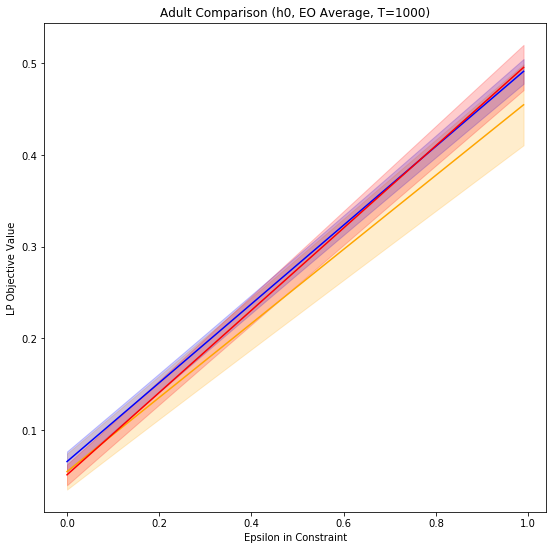

In [76]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, inprocessing_avg_objective_values_avgy0y1, 'orange')
plt.plot(epsilons, postprocessing_avg_objective_values_avgy0y1, 'blue')
plt.plot(epsilons, robust_avg_objective_values_avgy0y1, 'red')
plt.fill_between(epsilons, inprocessing_avg_objective_values_avgy0y1 - inprocessing_std_err, inprocessing_avg_objective_values_avgy0y1 + inprocessing_std_err, color='orange', alpha=0.2)
plt.fill_between(epsilons, postprocessing_avg_objective_values_avgy0y1 - postprocessing_std_err, postprocessing_avg_objective_values_avgy0y1 + postprocessing_std_err, color='blue', alpha=0.2)
plt.fill_between(epsilons, robust_avg_objective_values_avgy0y1 - robust_std_err, robust_avg_objective_values_avgy0y1 + robust_std_err, color='red', alpha=0.2)
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Adult Comparison (h0, EO Average, T=1000)')